In [17]:
from datasets import load_dataset

ds = load_dataset("kmrmanish/Employees_Reviews_Dataset")
print(ds)


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Title', 'Place', 'Job_type', 'Department', 'Date', 'Overall_rating', 'work_life_balance', 'skill_development', 'salary_and_benefits', 'job_security', 'career_growth', 'work_satisfaction', 'Likes', 'Dislikes'],
        num_rows: 86117
    })
})


In [18]:
df = ds['train'].to_pandas()


text_cols = ["Likes", "Dislikes", "Title", "Department"]

for col in text_cols:
    df[col] = df[col].astype(str).str.lower()


In [19]:
import pandas as pd

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

ratings = [
    "work_life_balance",
    "skill_development",
    "salary_and_benefits",
    "job_security",
    "career_growth",
    "work_satisfaction"
]

df[ratings] = df[ratings].fillna(df[ratings].median())


In [20]:
df["review_text"] = df["Likes"] + " " + df["Dislikes"]
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df["sentiment"] = df["review_text"].apply(
    lambda x: analyzer.polarity_scores(x)["compound"]
)


In [21]:
df["is_negative"] = df["sentiment"] < 0
df["low_rating"] = df["Overall_rating"] <= 2


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
X = vectorizer.fit_transform(df["review_text"])


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

features = ratings[:-1]  # exclude overall
X = df[features]
y = df["low_rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

model.score(X_test, y_test)


0.9243497445424989

In [24]:
#!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns


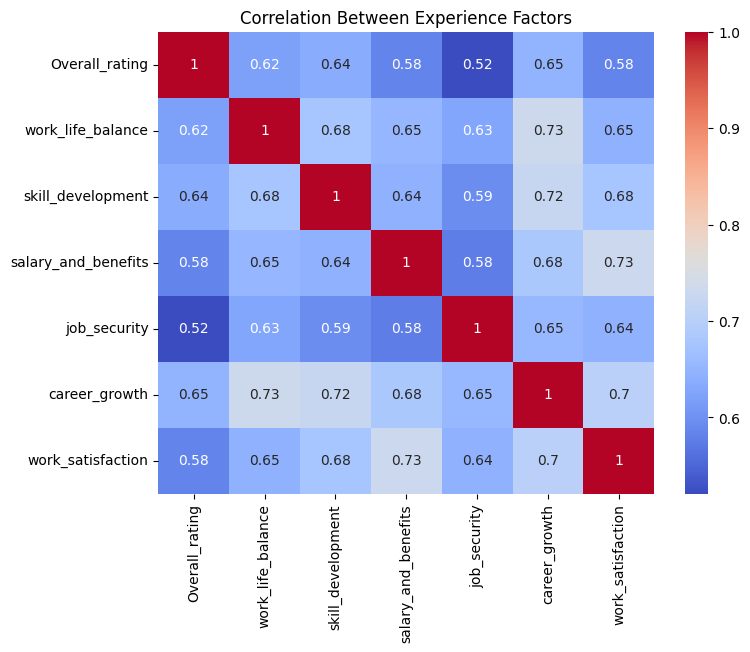

In [25]:
ratings = [
    "Overall_rating",
    "work_life_balance",
    "skill_development",
    "salary_and_benefits",
    "job_security",
    "career_growth",
    "work_satisfaction"
]

plt.figure(figsize=(8,6))
sns.heatmap(df[ratings].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Experience Factors")
plt.show()


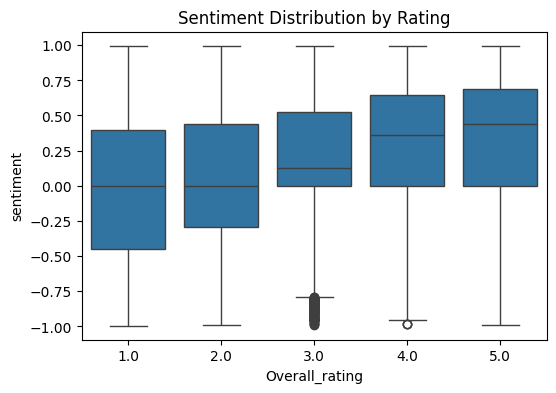

In [27]:
plt.figure(figsize=(6,4))

sns.boxplot(
    x="Overall_rating",
    y="sentiment",
    data=df
)

plt.title("Sentiment Distribution by Rating")
plt.show()


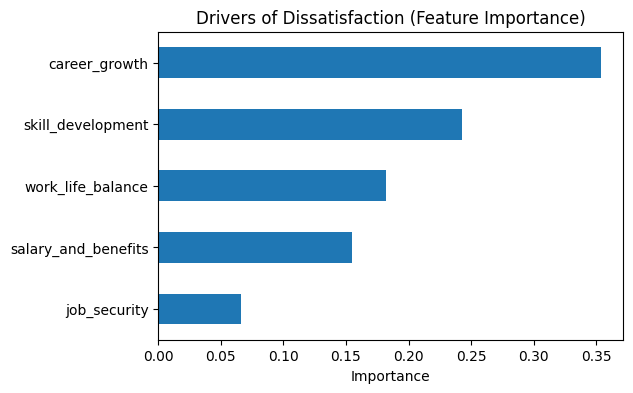

In [28]:
importance = pd.Series(model.feature_importances_, index=features)

plt.figure(figsize=(6,4))
importance.sort_values().plot(kind="barh")
plt.title("Drivers of Dissatisfaction (Feature Importance)")
plt.xlabel("Importance")
plt.show()


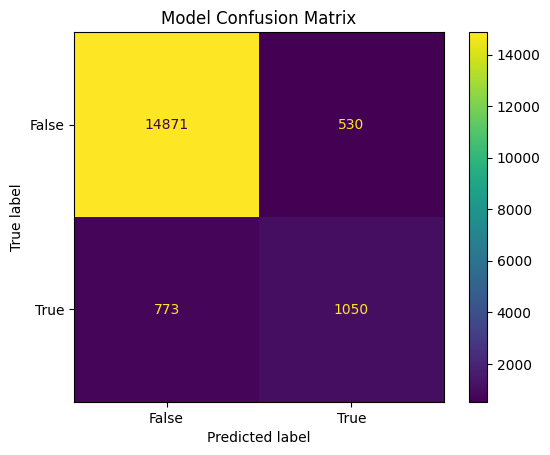

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Model Confusion Matrix")
plt.show()
